In [65]:
import numpy as np
import matplotlib.pyplot as plt
from Helper import *

In [85]:
#GRAPHS#
SMALL_SIZE = 22
MEDIUM_SIZE = 22
BIGGER_SIZE = 26

plt.rcParams['figure.figsize'] = [24, 8]

blue = 'royalblue'
red = 'crimson'
col1 = 'darkmagenta'
col2 = 'goldenrod'
col3 = 'mediumturquoise'
col4 ='forestgreen'

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [90]:
# constants

# 0 - male, 1 - female 
gender = [1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, # player 0 - 16
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, # 17 - 32
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, # 33 - 48
         0, 0, 0, 0, 1, 1, 1, 1, 0, 0 ,0 ,0, 0, 0, 0, 0 ] # 49 - 64 

# body, leftUpperArm, RightUpperArm, RightFoot, LeftFoot, LeftHand, RightHand
bodyPartsGroups= [0,1,1,2,2,3,3]
# 0 = right, 1 = hand
hand = [0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1]
gen = [0,1,1,1,0,0,0,0,1,1,1,1,0,1,0,0]
height = [1.7, 1.73, 1.65, 1.72, 1.77, 1.82, 1.81, 1.79, 1.6, 1.7, 1.7, 1.65, 1.8, 1.78, 1.84, 1.85 ]
colours = ["royalblue",col1, col3, col3, col1, col1, col3,"royalblue","crimson","crimson","crimson","crimson","royalblue","crimson","royalblue","royalblue"]
armLength = [28,23.5,27,27, 28, 27, 28, 26, 23, 26, 24, 26, 27, 24, 29, 29]
vrLength = [4.94, 3.90, 2.49, 3.39, 5.27, 5.09, 7.19, 4.14, 6.20, 3.00, 4.21, 4.90, 5.45, 2.87, 6.95, 2.70]
realLength = [ a * b / 100 for (a,b) in zip(armLength,vrLength) ]

weightPercentageMale = [0.551, 0.0325, 0.0325, 0.1668, 0.1668, 0.0252, 0.0252]
weightPercentageFemale = [0.532, 0.029, 0.029, 0.1843, 0.1843, 0.0207, 0.0207]

playersTraining = [2, 7, 11, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50, 54, 58, 62]
playersBaseline = [4, 9, 13, 16, 19, 24, 28, 31, 36, 39, 43, 48, 51, 56, 60, 63]
playersOptimal  = [3, 8, 12, 15, 20, 23, 27, 32, 35, 40, 44, 47, 52, 55, 59, 64]

path = "E:\\Andreea\\Master\\Thesis\\Git\\TheOne\\SmartuistWrapper\\tapResultParticipants.csv"
pathH = "C:\\Users\\huber\\OneDrive\\Dokumenty\\thesis-hubert\\unity\\SmartuistWrapper\\tapResultParticipants.csv"

In [68]:
def getStatisticsPhase3(results, players, limitLessons = 2):
    mvmTime = [] 
    gain = []
    efforBodyParts = []
    distBodyParts = []
    throughput = []
    for p in players:
        tmp = results[p]
        time = 0
        count = 0
        th = 0
        gain.append(getGainPerPlayer(p, results))
        effort, dist = EffortPerBodyPartPerPlayerSummed(p, results,10, limitLessons)
        efforBodyParts.append(effort)
        distBodyParts.append(dist)
        for words in tmp:
            if int(words[1]) < 2:
                time += float(words[10])
                th += float(words[11]) / (float(words[10]) / 1000) # recompute as id/time (not normalized id)
                count += 1
        throughput.append(th/count)        
        mvmTime.append(time/1000) # time in seconds
    return (mvmTime, gain, efforBodyParts, distBodyParts, throughput)

# computes the gain for the player (from effort per body part and throughput)
def getGainPerPlayer(p, results):
    gain = [] 
    batchSize = 10
    nrLessons = 2
    playerResults = results[p]
    for l in range(nrLessons):
        stupidTh = 0 
        sumTh = 0
        bodyParts =[ 0 for i in range(7)]
        for res in playerResults: #results for a repetition  
            if(l == int(res[1])):
                for i in range (7):
                    bodyParts[i] += 1 / float(res[21+i])
                sumTh += float(res[13])
                stupidTh += sumTh
        
        bodyParts = [ x / batchSize for x in bodyParts]
        gainEffort = sum(bodyParts) / len(bodyParts)
        gainTh = stupidTh / batchSize
        gain.append((gainEffort + gainTh) / 2)
    
    return np.average(gain)

# get effort and distance per body parts
def EffortPerBodyPartPerPlayerSummed(p, results, batchSize, limitLessons):
    effortBodyParts = [ 0 for i in range(7)]
    distBodyParts = [ 0 for i in range(7)]
    tmp = results[p]
    counter = 0
    for words in tmp:
        if int(words[1]) < limitLessons:
            for i in range (7):
                effortBodyParts[i] += float(words[21+i])
                distBodyParts[i] += float(words[14+i])

            counter = counter + 1
            if counter == batchSize:
                counter = 0
            if counter == 0:
                for i in range(7):
                    effortBodyParts[i] /= batchSize
                    distBodyParts[i] /= batchSize
    return (effortBodyParts, distBodyParts)

# a list with the results at idx for the given player    
def getResultPerPlayer(p, results, idx, unique ):
    tmp = results[p]
    values = []
    for words in tmp:
        values.append(float(words[idx]))
    if (unique == True):
        values =  [x for i, x in enumerate(values) if i == values.index(x)]
    return values

# sort list1 - use the indexes of the sorted list1 to rearrage list2    
def getCombinedPlot(list1, list2):
    idx   = np.argsort(list1)
    list1 = np.array(list1)[idx]
    list2 = np.array(list2)[idx]  
    return (list1, list2)

def EffortPerBodyPartPerPlayer(p, results):
    bodyParts =[ [0]*1 for i in range(7)]
    distBodyParts = [[0] * 1 for i in range (7)]
    tmp = results[p]
    counter = 0
    for words in tmp:            
        for i in range (7):
            bodyParts[i][bodyParts[i].index(bodyParts[i][-1])] += float(words[21+i])
            distBodyParts[i][distBodyParts[i].index(distBodyParts[i][-1])] += float(words[14+i])
        counter = counter + 1
        if counter == 10:
            counter = 0
        if counter == 0:
            for i in range(7):
                bodyParts[i][bodyParts[i].index(bodyParts[i][-1])] /= 10
                bodyParts[i].append(0)
                distBodyParts[i][distBodyParts[i].index(distBodyParts[i][-1])] /= 10
                distBodyParts[i].append(0)
    return (bodyParts, distBodyParts)

In [69]:
results = readFromFile(path, 0)
mvmTimeBaseline, gainBaseline, effortBaseline, distBaseline, thBaseline = getStatisticsPhase3(results, playersBaseline)
mvmTimeOptimal, gainOptimal, effortOptimal, distOptimal, thOptimal  = getStatisticsPhase3(results, playersOptimal)
mvmTimeFirst2, gainFirst2, effortFirst2, distFirst2, thFirst2  = getStatisticsPhase3(results, playersTraining)


In [70]:
def plotResultsPerBodyPart(baseline, optimal, title, yLabel, filename, legends):
    (l_legend, r_legend) = legends
    bodyParts = ["Body", "Left Upper Arm", "Right Upper Arm" , "Right Foot" , "Left Foot", "Left Hand" , "Right Hand", ]
    baseline = np.array(baseline)
    optimal = np.array(optimal)

    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(20,15))
#     fig.suptitle(title, y = 0.95)


    axs[0][0].boxplot([ baseline[:, 0], optimal[:, 0]], labels= [l_legend, r_legend])
    axs[0][1].boxplot([ baseline[:, 1], baseline[:, 2], optimal[:,1], optimal[:,2]], 
                   labels= [l_legend + "\n Left", l_legend + "\n Right", r_legend +  "\n Left", r_legend + "\n Right"])
    axs[1][0].boxplot([ baseline[:, 4], baseline[:, 3], optimal[:, 4],  optimal[:, 3]],
                   labels= [l_legend +  "\n Left", l_legend + "\n Right",  r_legend + "\n Left", r_legend + "\n Right"])

    axs[1][1].boxplot([ baseline[:, 5], baseline[:, 6], optimal[:,5], optimal[:,6]], 
                   labels= [l_legend +  "\n Left", l_legend + "\n Right", r_legend +  "\n Left", r_legend + "\n Right" ])


    axs[0][0].grid(True)
    axs[0][1].grid(True)
    axs[1][0].grid(True)
    axs[1][1].grid(True)
    axs[0][0].set_ylabel(yLabel)
    axs[0][0].set_title('Torso')
    axs[0][1].set_title('Upper arms')
    axs[1][0].set_title('Legs')
    axs[1][1].set_title('Hands')
    plt.tight_layout(w_pad=0.5, h_pad=1.5)
    plt.savefig(filename,bbox_inches='tight', dpi=150)
    plt.show()

#plotResultsPerBodyPart(effortBaseline, effortOptimal, "Effort per body part", "Effort", "EffortPerBodyPart", ("Baseline", "Optimal"))   
#plotResultsPerBodyPart(distBaseline, distOptimal, "Distance per body part", "Distance (m)", "DistancePerBodyPart", ("Baseline", "Optimal"))    
#plotResultsPerBodyPart(distBaseline, distFirst2, "Distance per body part", "Distance (m)", "DistancePerBodyPart", ("Baseline", "Initial"))    


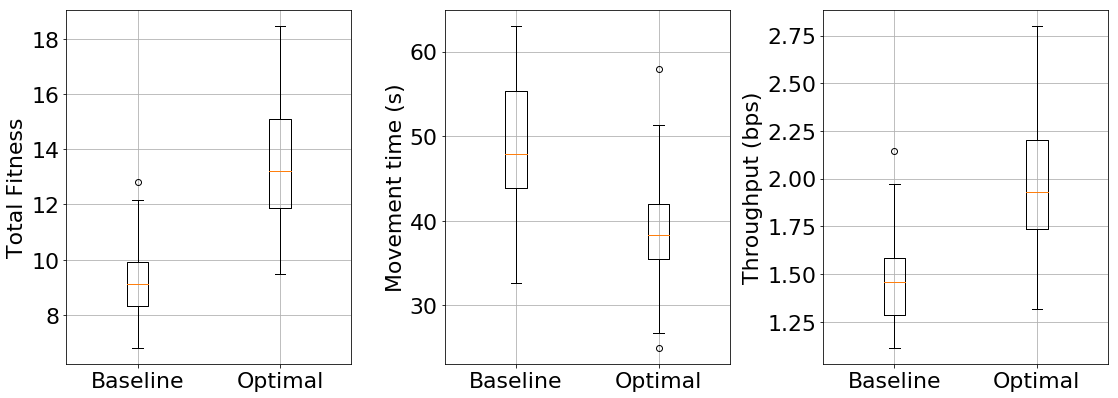

In [71]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(16,6))

axs[0].boxplot([gainBaseline, gainOptimal], labels= ["Baseline", "Optimal"])
#axs[0].set_title("Total Fitness")
axs[0].set_ylabel("Total Fitness")
axs[0].grid(True)

axs[1].boxplot([ mvmTimeBaseline, mvmTimeOptimal ], labels= ["Baseline", "Optimal"])
#axs[1].set_title("Movement time")
axs[1].set_ylabel("Movement time (s)")
axs[1].grid(True)

axs[2].boxplot([thBaseline, thOptimal], labels= ["Baseline", "Optimal"])
#axs[2].set_title("Throughput")
axs[2].set_ylabel("Throughput (bps)")
axs[2].grid(True)

plt.tight_layout()
plt.savefig("TotalGainMvmTime",bbox_inches='tight', dpi=150)

In [25]:
# mean and standard deviation 
print("Mean / std: movement time Baseline" , np.mean(mvmTimeBaseline), np.std(mvmTimeBaseline))
print("Mean / std: movement time Optimal" , np.mean(mvmTimeOptimal),  np.std(mvmTimeOptimal))

print("Mean / std: Throughput Baseline" , np.mean(thBaseline),  np.std(thBaseline))
print("Mean / std: Throughput Optimal" , np.mean(thOptimal),  np.std(thOptimal))

print("Mean / std: fitness Baseline" , np.mean(gainBaseline),  np.std(gainBaseline))
print("Mean / std: fitness time Optimal" , np.mean(gainOptimal),  np.std(gainOptimal))


Mean / std: movement time Baseline 48.264125 8.67269141382
Mean / std: movement time Optimal 39.2590625 8.01479433976
Mean / std: Throughput Baseline 2.90345298375 0.543143478666
Mean / std: Throughput Optimal 3.90810166125 0.736034883664
Mean / std: fitness Baseline 9.35158631031 1.72345165307
Mean / std: fitness time Optimal 13.5281663752 2.58266449049


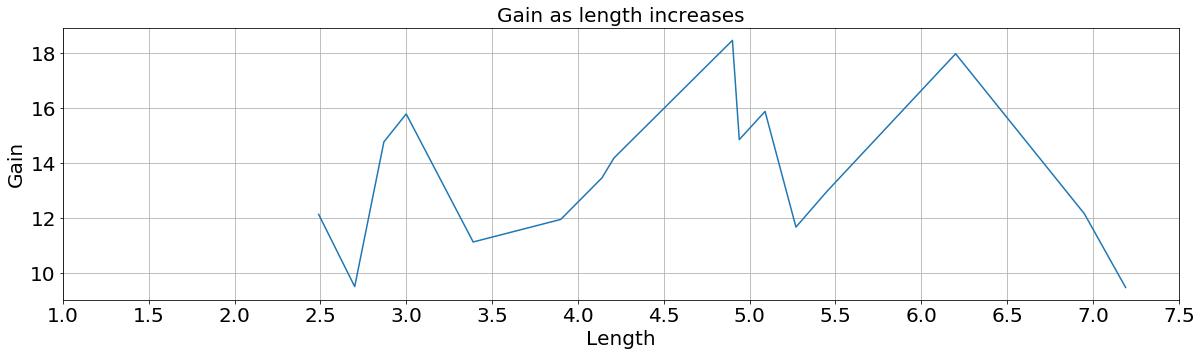

In [26]:
# gain as length increases - from baseline vs optimal 
plt.rcParams['figure.figsize'] = [20, 5]
lengthSorted, gainSorted = getCombinedPlot(vrLength, gainOptimal)
plt.plot(lengthSorted, gainSorted) 
plt.title("Gain as length increases")
plt.grid(True)
plt.ylabel("Gain")
plt.xlabel("Length")
plt.xticks(np.arange(1, 8, step=0.5))
plt.savefig("GainAsLengthIncreases",bbox_inches='tight', dpi=150)
plt.show()

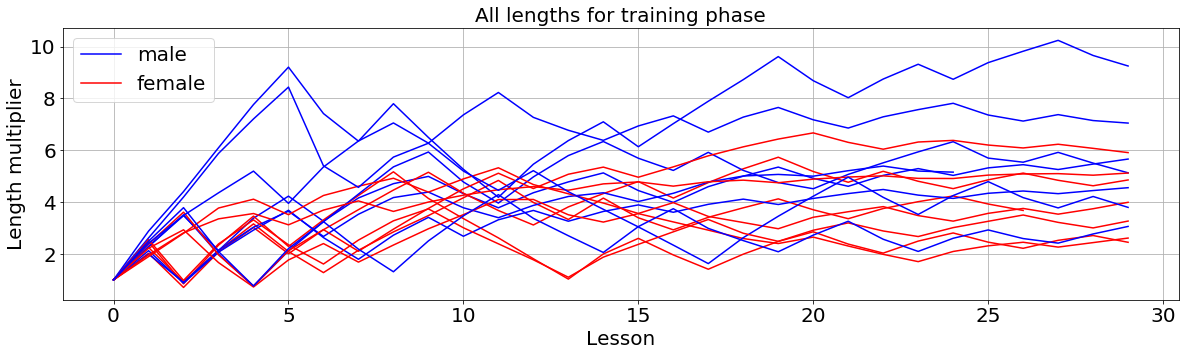

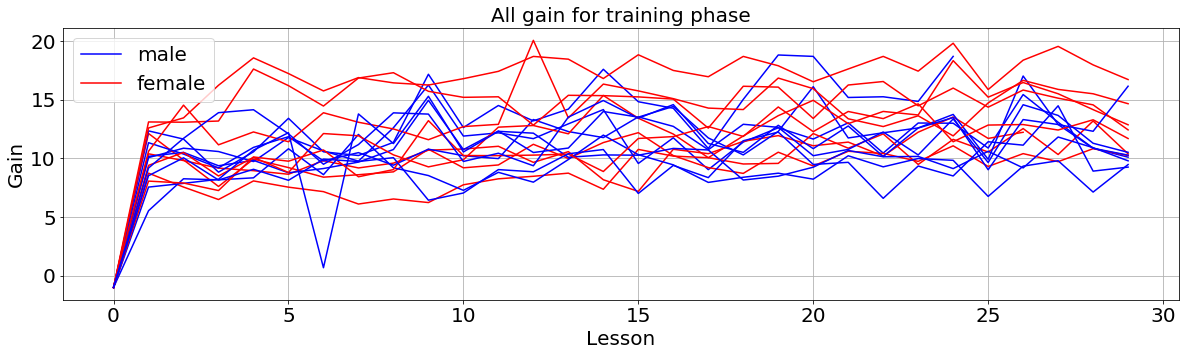

In [27]:
# phase1 results 
plt.rcParams['figure.figsize'] = [20, 5]
lengths = []
gainAllParticipants = [] 
for p in playersTraining:
    lengths.append(getResultPerPlayer(p, results, 28, True ))
    gainAllParticipants.append(getResultPerPlayer(p, results, 29, True ))

for i in range(len(lengths)): # print all lengths 
    l = lengths[i]
    x = list(range(0, len(l)))
    if(gender[playersTraining[i]] == 0):
        plt.plot(x, l, "b") 
    else:
        plt.plot(x, l, "r")

plt.title("All lengths for training phase")
plt.grid(True)
plt.ylabel("Length multiplier")
plt.xlabel("Lesson")
plt.savefig("AllLengthsPhase1",bbox_inches='tight', dpi=150)
plt.legend(["male", "female"], loc='upper left')
plt.show()

for i in range(len(gainAllParticipants)): 
    l = gainAllParticipants[i]
    x = list(range(0, len(l)))
    if(gender[playersTraining[i]] == 0):
        plt.plot(x, l, "b")   
       
    else:
        plt.plot(x, l, "r")
        
    
plt.title("All gain for training phase")
plt.grid(True)
plt.legend(["male", "female"], loc='upper left')
plt.ylabel("Gain")
plt.xlabel("Lesson")
plt.savefig("AllGainsPhase1",bbox_inches='tight', dpi=150)
plt.show()

sortedGain = []
sortedLengths = []




In [28]:
age = [25, 25, 27, 24, 27, 28, 25, 24, 26, 24, 25, 21, 32, 27, 26, 40]
heightM = [170, 177, 182, 181, 179, 180, 184, 185]
heightF = [173, 165, 172, 160, 170, 170, 165, 178]
print("Mean age: ", np.mean(age))
print("Mean height male: ", np.mean(heightM))
print("Mean height female: ", np.mean(heightF))

Mean age:  26.625
Mean height male:  179.75
Mean height female:  169.125


In [31]:
lengthsForAvg = []
fitnessForAvg = []

lengths = []
fintess = []

i = 0
for p in playersTraining:
    l = getResultPerPlayer(p, results, 28, True )
    l = [x * armLength[i] / 100 for x in l]
    lengths.append(l)
    f = getResultPerPlayer(p, results, 29, True )
    fintess.append(f)
    lengthsForAvg.append(l) 
    fitnessForAvg.append(f)
    i += 1
    
avgLengths = []

minLen = []
maxLen  = []

N = len(maleLengths)

topLen = max(list(map(lambda x: len(x), lengthsForAvg)))

for i in range(topLen):
    tmp = 0
    tmin = 100
    tmax = 0
    for j in range(N):
        try:
            t = lengthsForAvg[j][i]
            tmp += t
            if t < tmin:
                tmin = t
            if t > tmax:
                tmax = t
        except IndexError:
            print("nope M")
    avgLengths.append(tmp/maleN)
    maxLen.append(tmax)
    minLen.append(tmin)
    


nope M
nope M
nope M
nope M
nope M
nope M
nope M
nope M


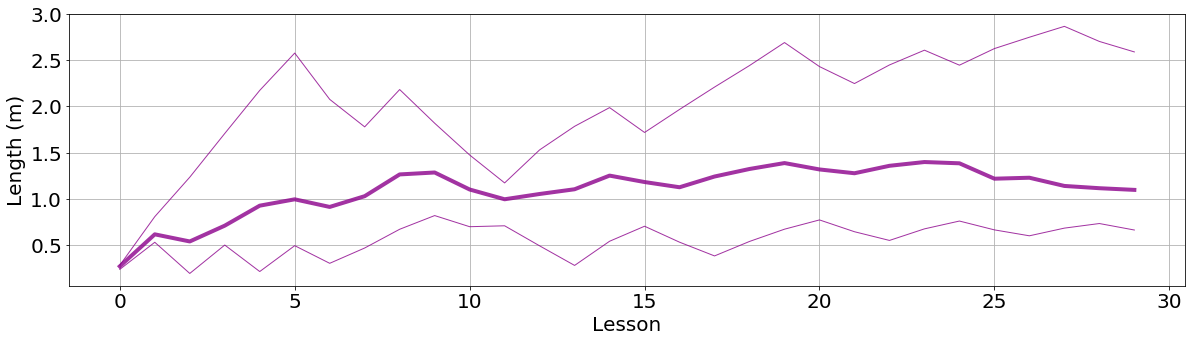

In [37]:
lengths = []
gainAllParticipants = []
colours = [red, blue]
width = [1,4,1,1,4,1]

tmp = [maxLen,avgLengths,minLen]

i = 0
for p in range(len(tmp)):
    plt.plot(range(len(tmp[p])), tmp[p], col1, linewidth = width[i], alpha=0.8)
    i += 1


plt.grid(True)
plt.ylabel("Length (m)")
plt.xlabel("Lesson")
plt.savefig("MeanLengthsTrainingTrend",bbox_inches='tight', dpi=150)
plt.show()

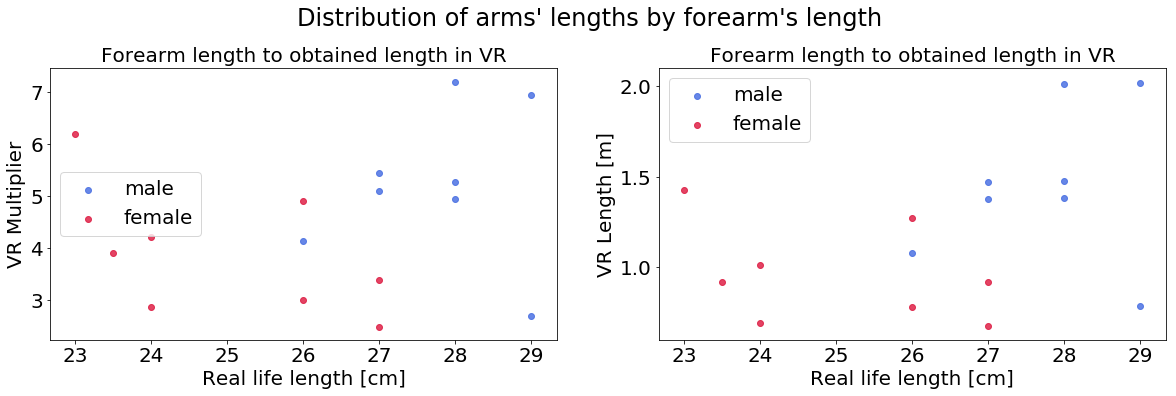

In [38]:

fig, (ax1, ax2) = plt.subplots( ncols = 2)

for p in range(len(vrLength)):
    if gen[p] == 0:
        ax1.scatter(armLength[p], vrLength[p], alpha=0.8, color=blue)
    else:
        ax1.scatter(armLength[p], vrLength[p], alpha=0.8, color=red)


ax1.set_title('Forearm length to obtained length in VR')
ax1.set_xlabel('Real life length [cm]')
ax1.set_ylabel('VR Multiplier')
ax1.legend(('male', 'female'), loc='best')

for p in range(len(realLength)):
    if gen[p] == 0:
        ax2.scatter(armLength[p], realLength[p], alpha=0.8, color=blue)
    else:
        ax2.scatter(armLength[p], realLength[p], alpha=0.8, color=red)
ax2.set_title('Forearm length to obtained length in VR')
ax2.set_xlabel('Real life length [cm]')
ax2.set_ylabel('VR Length [m]')

ax2.legend(('male', 'female'), loc='best')

fig.suptitle("Distribution of arms' lengths by forearm's length", y = 1.05)
plt.savefig("ForeamrsLengthOverForearms",bbox_inches='tight', dpi=150)

plt.show()

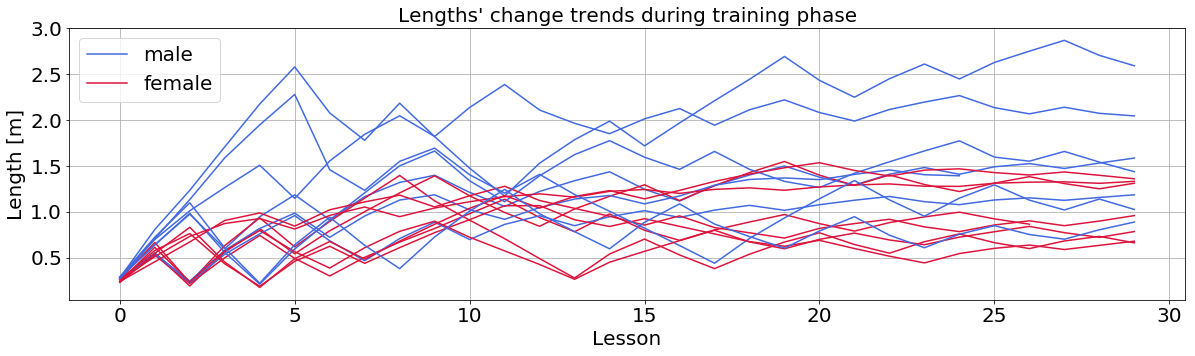

In [39]:
plt.rcParams['figure.figsize'] = [20, 5]
lengths = []
gainAllParticipants = [] 
for p in playersTraining:
    lengths.append(getResultPerPlayer(p, results, 28, True ))
    gainAllParticipants.append(getResultPerPlayer(p, results, 29, True ))


for i in range(len(lengths)): # print all lengths 
    l = lengths[i]
    l = [x * armLength[i] / 100 for x in l]
    x = list(range(0, len(l)))
    if(gender[playersTraining[i]] == 0):
        plt.plot(x, l, blue) 
    else:
        plt.plot(x, l, red)
        
plt.title("Lengths' change trends during training phase")
plt.grid(True)
plt.ylabel("Length [m]")
plt.xlabel("Lesson")
plt.savefig("AllRealLengthsPhase1",bbox_inches='tight', dpi=150)
plt.legend(["male", "female"], loc='upper left')
plt.savefig("LengthsTrendTraining",bbox_inches='tight', dpi=150)
plt.show()

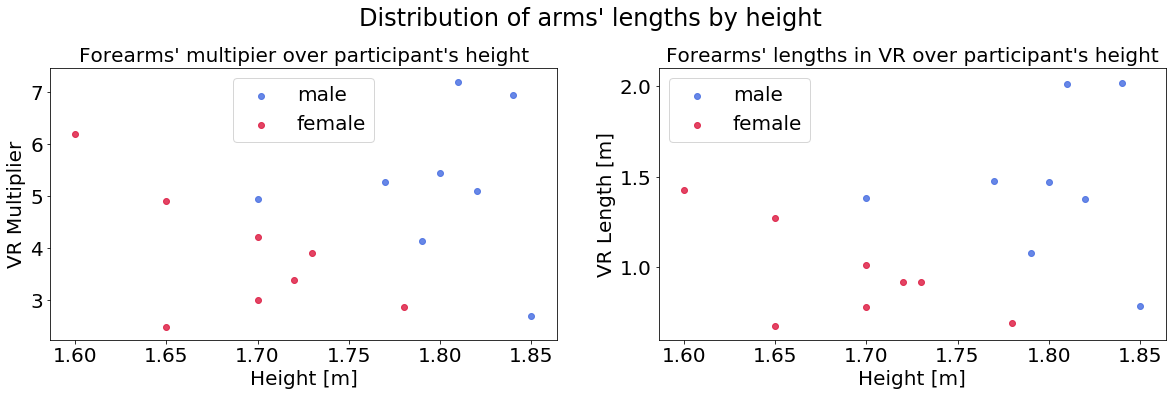

In [40]:
fig, (ax1, ax2) = plt.subplots( ncols = 2)

for p in range(len(vrLength)):
    if gen[p] == 0:
        ax1.scatter(height[p], vrLength[p], alpha=0.8, color=blue)
    else:
        ax1.scatter(height[p], vrLength[p], alpha=0.8, color=red)


ax1.set_title('Forearms\' multipier over participant\'s height')
ax1.set_xlabel('Height [m]')
ax1.set_ylabel('VR Multiplier')
ax1.legend(('male', 'female'), loc='best')

for p in range(len(realLength)):
    if gen[p] == 0:
        ax2.scatter(height[p], realLength[p], alpha=0.8, color=blue)
    else:
        ax2.scatter(height[p], realLength[p], alpha=0.8, color=red)
ax2.set_title('Forearms\' lengths in VR over participant\'s height')
ax2.set_xlabel('Height [m]')
ax2.set_ylabel('VR Length [m]')

ax2.legend(('male', 'female'), loc='best')

fig.suptitle("Distribution of arms' lengths by height", y = 1.05)
plt.savefig("ForeamrsLengthOverHeight",bbox_inches='tight', dpi=150)

plt.show()

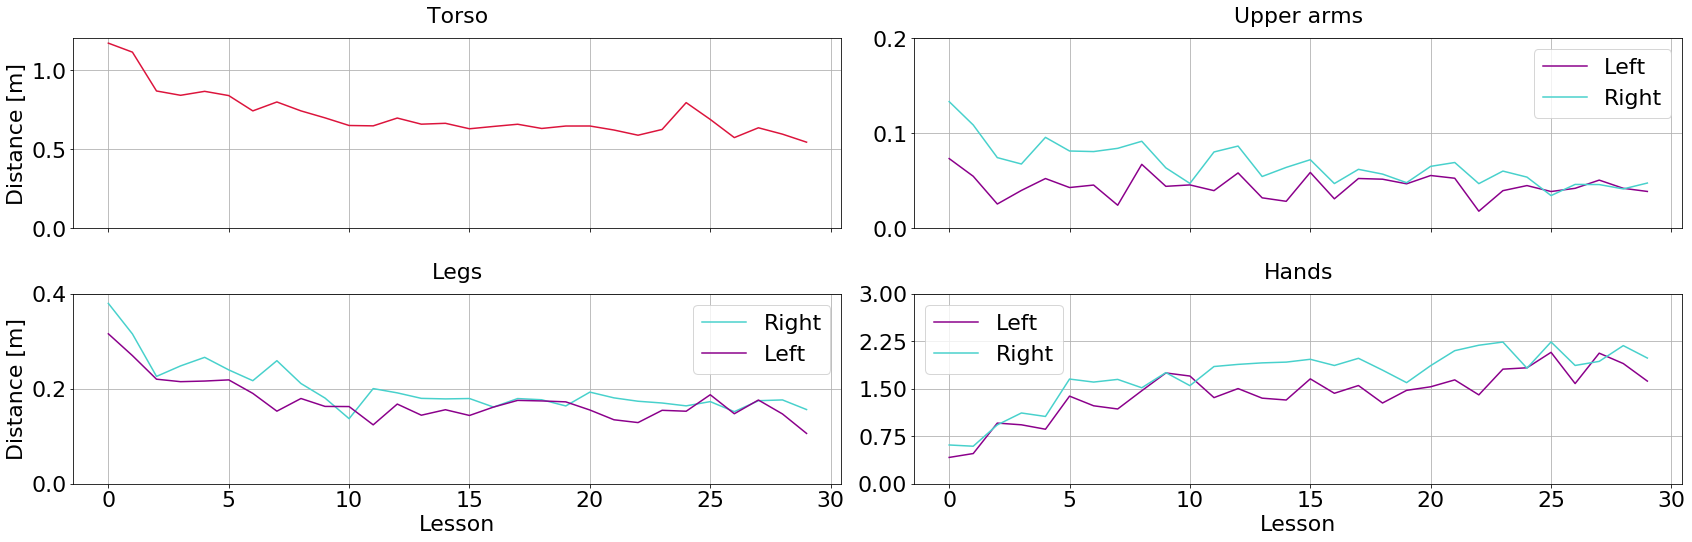

In [91]:
fig, ax = plt.subplots( ncols = 2, nrows=2, sharex=True, sharey=False)

first = True

for p in playersTraining:
    (efforts, dist) = EffortPerBodyPartPerPlayer(p,results)
    tmp = np.matrix(dist)
    if dist[0][6] > 5:
        continue
    if first:
        acc = tmp
        first = False
    else:
        if acc.shape != tmp.shape:
            (x,y) = acc.shape
            (a,b) = tmp.shape
            tmp = np.pad(tmp,((0,0),(0,y-b)),'constant')
        acc = np.add(acc,tmp)

avg = np.true_divide(acc,len(playersTraining))
avg = np.delete(avg, [30,31], axis=1).tolist()

c1 = True
c11 = True

for i in range(len(avg)):
   
    y = avg[i]
    x = range(len(y))
    if (i > 0):
        y = [avg[i][k] - avg[0][k] for k in range(len(avg[i]))]
    
    if bodyPartsGroups[i] == 0:
        ax[0][0].plot(x,y, color = red)
        ax[0][0].set_title("Torso", y = 1.05)
        ax[0][0].set_yticks(np.arange(0,1.5, 0.5))
        ax[0][0].grid(True)
#         ax[0][0].legend((),loc='best')
    elif bodyPartsGroups[i] == 1:
        ax[0][1].plot(x,y, color = colours[i])
        ax[0][1].set_title("Upper arms", y = 1.05)
        ax[0][1].set_yticks(np.arange(0,0.3, 0.1))
        ax[0][1].grid(True)
        ax[0][1].legend(('Left', 'Right'), loc='best')
    elif bodyPartsGroups[i] == 3: 
        ax[1][1].plot(x,y, color = colours[i])
        ax[1][1].set_title("Hands", y = 1.05)
        ax[1][1].set_yticks(np.arange(0,3.25, 0.75))
        ax[1][1].legend(('Left', 'Right'), loc='best')
        ax[1][1].grid(True)
    else:
        ax[1][0].plot(x,y, color = colours[i])
        ax[1][0].set_title("Legs", y = 1.05)
        ax[1][0].legend(('Right', 'Left'), loc='best')
        ax[1][0].set_yticks(np.arange(0,0.6, 0.2))
        ax[1][0].grid(True)
        
ax[0][0].set_ylabel('Distance [m]')
ax[1][0].set_ylabel('Distance [m]')

ax[1][0].set_xlabel('Lesson')
ax[1][1].set_xlabel('Lesson')
  
plt.tight_layout(w_pad=0.5, h_pad=1.0)

# plt.subplots_adjust(top=1.5, bottom = 0.05)
plt.savefig("DistancesBodyPartsTraining2",bbox_inches='tight', dpi=150)
plt.show()

In [ ]:
first = True
fig, (ax1, ax2, ax3) = plt.subplots( ncols = 3)

for i in range(len(avg)):
    y = avg[i]
    x = range(len(y))
    if bodyPartsGroups[i] == 0:
        ax1.plot(x,y)
    elif bodyPartsGroups[i] == 1 or bodyPartsGroups[i] == 3:
        ax2.plot(x,y)
    else:
        ax3.plot(x,y)

plt.show()


In [ ]:
lHR = []
lHL = []
rHR = []
rHL = []
for i in range(len(playersTraining)):
    efforts, dist = EffortPerBodyPartPerPlayer(playersTraining[i],results)
    if hand[i] == 0:
        rHL.append(dist[5][:30])
        rHR.append(dist[6][:30])
    else:
        lHL.append(dist[5][:30])
        lHR.append(dist[6][:30])
        
fig, ax = plt.subplots( ncols = 2, nrows=2, sharex=True, sharey=True)

for y in rHR:
    ax[0][0].plot(range(len(y)), y)
    
for y in rHL:
    ax[0][1].plot(range(len(y)), y)

for y in lHR:
    ax[1][0].plot(range(len(y)), y)
    
for y in lHL:
    ax[1][1].plot(range(len(y)), y)
    
ax[0][0].set_title("Right Handed | Right Hand", y = 1.05)
ax[0][1].set_title("Right Handed | Left Hand", y = 1.05)
ax[1][0].set_title("Left Handed | Right Hand", y = 1.05)
ax[1][1].set_title("Left Handed | Left Hand", y = 1.05)

ax[0][0].set_ylabel('Distance [m]')
ax[1][0].set_ylabel('Distance [m]')

ax[1][0].set_xlabel('Lesson')
ax[1][1].set_xlabel('Lesson')

plt.tight_layout(w_pad=0.86, h_pad=1.0)
plt.subplots_adjust(top=1.5, bottom = 0.05)
fig.suptitle("Distances travelled by hands based on dominant hand during training phase", y = 1.75)
plt.savefig("HandednessDistancesTraining",bbox_inches='tight', dpi=150)
plt.show()



In [ ]:
lHR = 0
lHL = 0
rHR = 0
rHL = 0

k  = 0
m = 0
for i in range(len(playersTraining)):
    
    if hand[i] == 0:
        rHL += (distOptimal[i][5])
        rHR += (distOptimal[i][6])
        k += 1
    else:
        lHL +=(distOptimal[i][5])
        lHR += (distOptimal[i][6])
        m += 1
        
lHR = lHR / m
lHL = lHL / m
rHR = rHR / k
rHL = rHL / k      
n_groups = 2
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rightHand = [rHL, rHR]
leftHand = [lHL, lHR]

rects1 = plt.bar(index, leftHand, bar_width,
alpha=opacity,
color=red,
label='Left Handed')

rects2 = plt.bar(index + bar_width, rightHand, bar_width,
alpha=opacity,
color=blue,
label='Right Handed')


plt.xlabel('')
plt.ylabel('Avg Distance [m]')
plt.title('Handedness effect on distances travelled by hands')
plt.xticks(index + bar_width/2, ('Left Hand', 'Right Hand'))
plt.legend()
plt.grid(True)
plt.savefig("HandednessDistances",bbox_inches='tight', dpi=150)
plt.show()

In [ ]:
plotResultsPerBodyPart(distBaseline, distFirstTries, "Distance per body part", "Distance (m)", "DistancePerBodyPart") 